In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import OrderedDict

np.random.seed(42)

## Read Data

In [2]:
df = pd.read_csv("V2_ENG_interview_dataset.csv", dtype=str, infer_datetime_format=True)

Drop bad rows and cols

In [3]:
df = df.loc[df["Unnamed: 10"].isna()]
df = df.dropna(axis=1)

Test if are bad Lines


In [4]:
pd.to_numeric(df["Amount"], errors="raise");

Correct Data types

In [5]:
types = {"Year-Month":int, "Agency Number":int,	"Agency Name":str, "Cardholder Last Name":str, "Cardholder First Initial":str, "Amount":float, "Vendor":str, "Transaction Date":str, "Posted Date":str,	"Merchant Category Code (MCC)":str}

In [6]:
df = df.astype(types)
df["Posted Date"] = pd.to_datetime(df["Posted Date"])
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])

Format Data

In [7]:
df["Days Delay"] = (df["Posted Date"] - df["Transaction Date"]).dt.days
df.insert(1, "Year", df["Year-Month"]//100)
df.insert(2, "Month", df["Year-Month"]%100)
df.drop("Year-Month", axis=1, inplace=True)

In [8]:
df_op = df.loc[df["Amount"] > 0]

Visualize Data

In [9]:
pd.DataFrame(df_op['Merchant Category Code (MCC)'].value_counts())

,Merchant Category Code (MCC)
"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRITING PAPER",23998
BOOK STORES,21392
INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED,21026
DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP AND SUP.,19805
"GROCERY STORES,AND SUPERMARKETS",16688
...,...
TAJ HOTELS INT'L,1
VIRGIN ATLANTIC,1
SWISS INTERNATIONAL AIR LINES,1
AMBULANCE SERVICES,1


In [10]:
pd.DataFrame(df_op['Cardholder Last Name'].value_counts())

,Cardholder Last Name
JOURNEY HOUSE TRAVEL INC,9650
UNIVERSITY AMERICAN,6997
JOURNEY HOUSE TRAVEL,4511
Heusel,4050
Hines,3322
...,...
KRAMER,1
Bonds,1
McMaine,1
Cabiran,1


In [11]:
df_op.head(5)

,Year,Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),Days Delay
0,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,1
1,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,1
2,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2
3,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",1
4,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",1


##  XGBoost

Defining constants

In [15]:
person = 'UNIVERSITY AMERICAN'

cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name'] + numeric_vars + cat_vars
num_rounds = 10
params = {
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

Organizing dataset

In [16]:
df_cp = df_op[categories].copy()
df_cp["labels"] = (df_cp['Cardholder Last Name'] == person)

In [17]:
cat_data = pd.get_dummies(df_cp[cat_vars])
numeric_data = df_cp[numeric_vars].copy()
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)
numeric_cat_label_data = pd.concat([numeric_cat_data, df_cp["labels"].copy()], axis=1)

In [18]:
df_true_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == True].copy()
df_false_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == False].sample(n=df_true_transations.shape[0]).copy()
df_transations = pd.concat([df_true_transations, df_false_transations], axis=0)
labels = df_transations['labels']
df_transations.drop('labels', axis=1, inplace=True)

Training model

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [20]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.61163	train-logloss:0.61192
[1]	test-logloss:0.54488	train-logloss:0.54545
[2]	test-logloss:0.48937	train-logloss:0.49021
[3]	test-logloss:0.44270	train-logloss:0.44374
[4]	test-logloss:0.40302	train-logloss:0.40431
[5]	test-logloss:0.36908	train-logloss:0.37059
[6]	test-logloss:0.33981	train-logloss:0.34154
[7]	test-logloss:0.31440	train-logloss:0.31643
[8]	test-logloss:0.29196	train-logloss:0.29425
[9]	test-logloss:0.27257	train-logloss:0.27496


See results

In [21]:
threshold = .5
true_labels = y_test.astype(int)

In [22]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [23]:
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9816882076454956


In [24]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9648470991711918


Confusion Matrix :


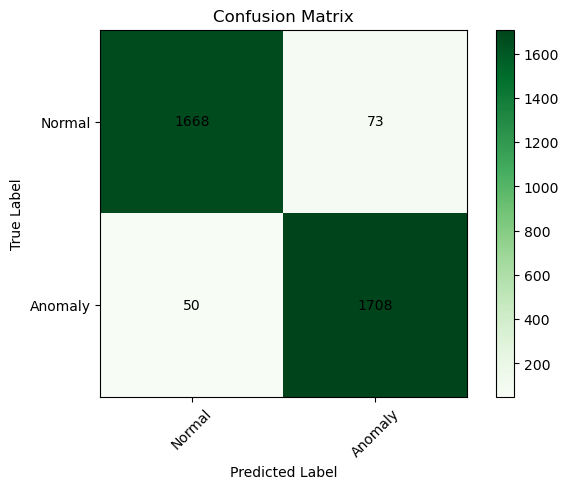

In [25]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

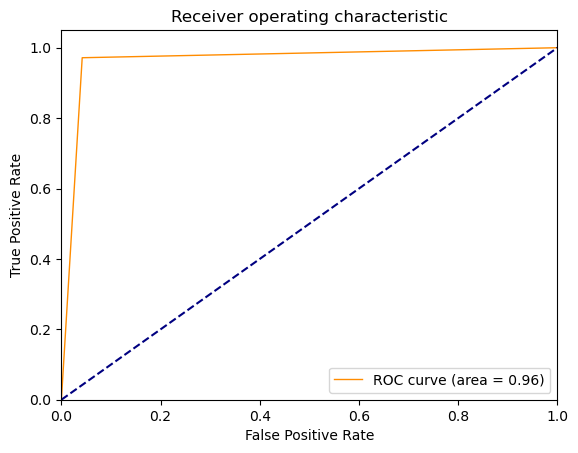

In [26]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

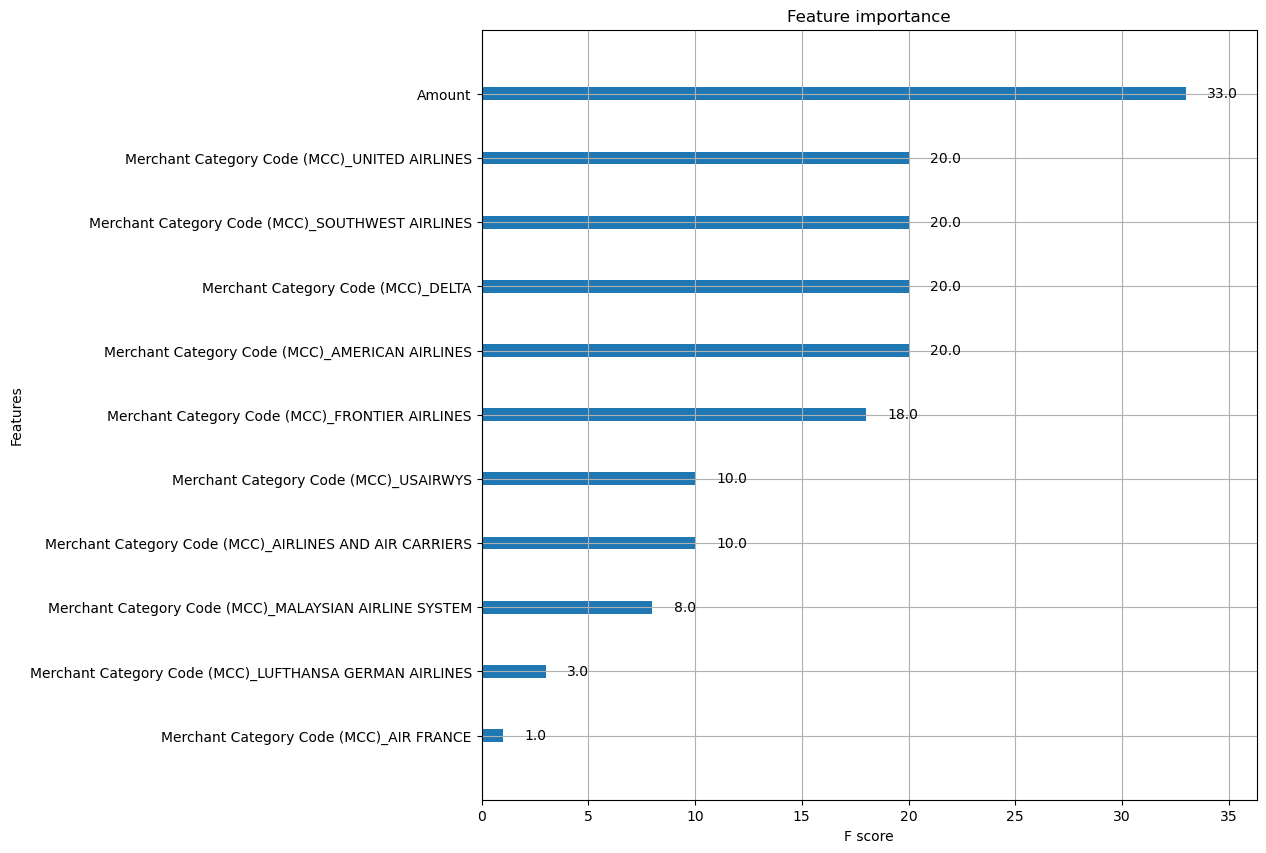

In [27]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

Test for all Dataset

In [28]:
df_true_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == True].copy()
df_false_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == False].copy()
df_transations = pd.concat([df_true_transations, df_false_transations], axis=0)
labels = df_transations['labels']
df_transations.drop('labels', axis=1, inplace=True)

In [29]:
dtest = xgb.DMatrix(df_transations, label=labels)

In [30]:
threshold = .5
true_labels = labels.astype(int)

In [31]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [32]:
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9795242379842959


In [33]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9514698867303322


Test for all persons

In [34]:
def calc_accuracy(name: str):
    df_cp["labels"] = (df_cp['Cardholder Last Name'] == name)
    cat_data = pd.get_dummies(df_cp[cat_vars])
    numeric_data = df_cp[numeric_vars].copy()
    numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)
    numeric_cat_label_data = pd.concat([numeric_cat_data, df_cp["labels"].copy()], axis=1)
    df_true_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == True].copy()
    df_false_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == False].sample(n=df_true_transations.shape[0]).copy()
    df_transations = pd.concat([df_true_transations, df_false_transations], axis=0)
    labels = df_transations['labels']
    df_transations.drop('labels', axis=1, inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evals = [(dtest, 'test'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_rounds, evals=evals)
    true_labels = y_test.astype(int)
    preds = model.predict(dtest)
    pred_labels = (preds > threshold).astype(int)
    return accuracy_score(true_labels, pred_labels)

In [35]:
persons = list(df_op['Cardholder Last Name'].unique())
quantities = df_op['Cardholder Last Name'].value_counts()
values = []
names = []

In [36]:
for person in persons:
    if quantities[person] > 1000:
        accuracy = calc_accuracy(person)
        values.append(accuracy) 
        names.append(quantities[person])

[0]	test-logloss:0.67248	train-logloss:0.67327
[1]	test-logloss:0.65646	train-logloss:0.65741
[2]	test-logloss:0.64209	train-logloss:0.64217
[3]	test-logloss:0.62963	train-logloss:0.62956
[4]	test-logloss:0.62001	train-logloss:0.62014
[5]	test-logloss:0.61137	train-logloss:0.61133
[6]	test-logloss:0.60406	train-logloss:0.60418
[7]	test-logloss:0.59873	train-logloss:0.59861
[8]	test-logloss:0.59403	train-logloss:0.59376
[9]	test-logloss:0.59085	train-logloss:0.58975
[0]	test-logloss:0.68643	train-logloss:0.68487
[1]	test-logloss:0.68163	train-logloss:0.67860
[2]	test-logloss:0.67847	train-logloss:0.67392
[3]	test-logloss:0.67606	train-logloss:0.67043
[4]	test-logloss:0.67471	train-logloss:0.66778
[5]	test-logloss:0.67354	train-logloss:0.66572
[6]	test-logloss:0.67274	train-logloss:0.66423
[7]	test-logloss:0.67304	train-logloss:0.66329
[8]	test-logloss:0.67312	train-logloss:0.66271
[9]	test-logloss:0.67400	train-logloss:0.66241
[0]	test-logloss:0.68348	train-logloss:0.68253
[1]	test-logl

Text(0, 0.5, 'Accuracy')

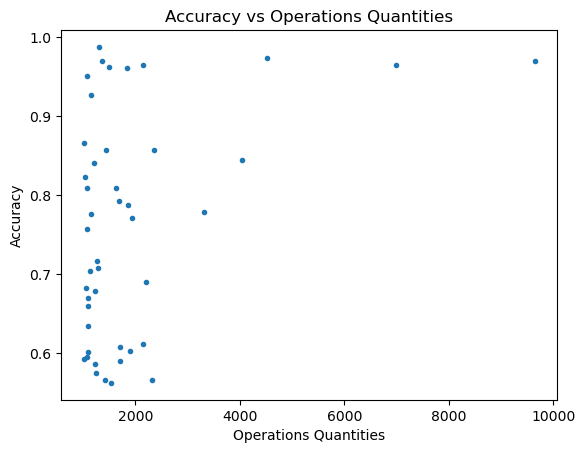

In [37]:
plt.figure()
plt.plot(names, values, ".")
plt.title("Accuracy vs Operations Quantities")
plt.xlabel("Operations Quantities")
plt.ylabel("Accuracy")